In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
GRAVITY = np.array([0.0, 0.0, -9.80665])  # ENU frame (z up)


In [2]:
def quat_normalize(q):
    return q / np.linalg.norm(q)

def quat_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quat_from_gyro(omega, dt):
    """
    Small-angle quaternion from body-frame angular rate
    """
    theta = np.linalg.norm(omega) * dt
    if theta < 1e-8:
        return np.array([1.0, 0.0, 0.0, 0.0])
    axis = omega / np.linalg.norm(omega)
    half = theta / 2.0
    return quat_normalize(
        np.array([
            np.cos(half),
            axis[0]*np.sin(half),
            axis[1]*np.sin(half),
            axis[2]*np.sin(half)
        ])
    )

def quat_rotate(q, v):
    """
    Rotate vector v from body → world using quaternion q
    """
    qv = np.array([0.0, *v])
    return quat_multiply(quat_multiply(q, qv), quat_conj(q))[1:]

def quat_conj(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])


In [3]:
@dataclass
class INSState:
    p: np.ndarray   # position (m)
    v: np.ndarray   # velocity (m/s)
    q: np.ndarray   # quaternion (w, x, y, z)


In [4]:
def ins_propagate(state, acc_body, gyro_body, dt):
    # 1. Attitude update
    dq = quat_from_gyro(gyro_body, dt)
    q_new = quat_normalize(quat_multiply(state.q, dq))

    # 2. Acceleration to world frame
    acc_world = quat_rotate(q_new, acc_body) + GRAVITY

    # 3. Velocity update
    v_new = state.v + acc_world * dt

    # 4. Position update
    p_new = state.p + v_new * dt

    return INSState(p=p_new, v=v_new, q=q_new)


In [5]:
dt = 0.01          # 100 Hz
T = 1800           # 30 minutes
N = int(T / dt)

# Gyro bias (rad/s)
gyro_bias = np.array([0.002, 0.001, 0.001])

# Accel bias (m/s^2)
acc_bias = np.array([0.02, 0.01, 0.03])

# Initial state
state = INSState(
    p=np.zeros(3),
    v=np.zeros(3),
    q=np.array([1.0, 0.0, 0.0, 0.0])
)


In [6]:
positions = []
attitude_error = []

for i in range(N):
    acc_meas = acc_bias + np.random.randn(3) * 0.02
    gyro_meas = gyro_bias + np.random.randn(3) * 0.0005

    state = ins_propagate(state, acc_meas, gyro_meas, dt)

    positions.append(state.p.copy())

    # Attitude error proxy (angle from identity)
    qw = np.clip(state.q[0], -1.0, 1.0)
    angle = 2 * np.arccos(qw)
    attitude_error.append(angle)


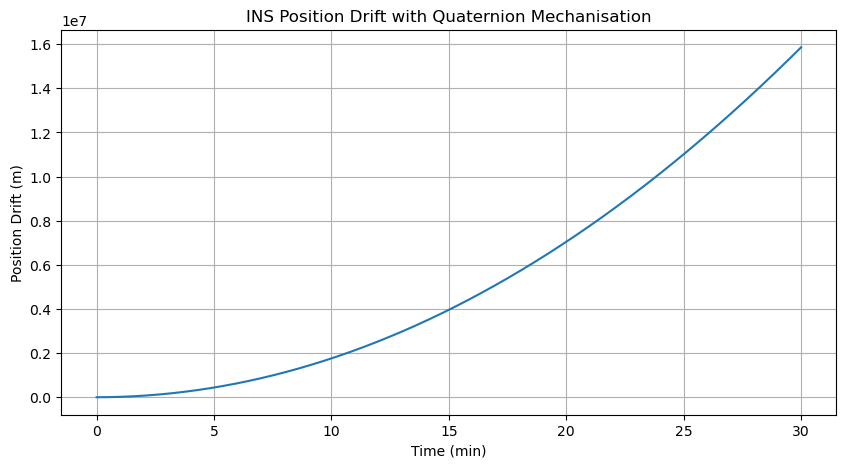

In [7]:
positions = np.array(positions)
t = np.arange(N) * dt / 60

plt.figure(figsize=(10,5))
plt.plot(t, np.linalg.norm(positions, axis=1))
plt.xlabel("Time (min)")
plt.ylabel("Position Drift (m)")
plt.title("INS Position Drift with Quaternion Mechanisation")
plt.grid(True)
plt.show()


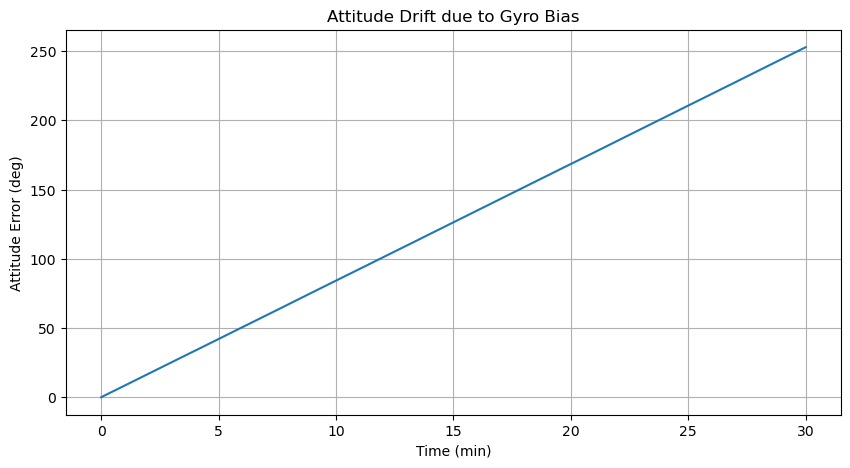

In [8]:
plt.figure(figsize=(10,5))
plt.plot(t, np.rad2deg(attitude_error))
plt.xlabel("Time (min)")
plt.ylabel("Attitude Error (deg)")
plt.title("Attitude Drift due to Gyro Bias")
plt.grid(True)
plt.show()
